In [183]:
import networkx as nx

In [184]:
from networkx.algorithms import community as cty

In [185]:
from networkx.algorithms.community import k_clique_communities

In [186]:
from networkx.algorithms.community import greedy_modularity_communities

In [187]:
import csv

Functions to generate an adjacency list that Networkx can create a graph from.

In [188]:
# Final variables
INTERACTION_QUESTIONS_START = 6
FREQUENCY = {"Never": 0, "Less than once a week": 1, "Once a week": 2, "A few times a week": 3, "Every day": 4}
DISTANCE = {"Never": 4, "Less than once a week": 3, "Once a week": 2, "A few times a week": 1, "Every day": 0}
INTERACTION_TYPE = {"Within Reclass": 0, "Outside of Reclass": 1, "About the same within and outside of Reclass": 2}

In [189]:
# get_firstname: returns the first word (a name) in a string of words
def get_firstname(str):
    length = len(str)
    for i in range(length):
        if str[i] == " ":
            return str[0:i]
    return str

In [190]:
# make_node_dict: parses the csv response file to get the column and associated name of every "interaction" question, and 
# returns those pairs in a dictionary. 
# Even #'s: Interaction Frequency (interactions per week)
# Odd #'s: Interaction Type (within or outside Reclass)
def make_node_dict(file):
    responses = open(file, "r")
    reader = csv.reader(responses, delimiter=',')
    nodes = {}
    for row in reader:
        length = len(row)
        i = INTERACTION_QUESTIONS_START
        while i < length:
            nodes[i] = get_firstname(row[i])
            i += 1
        break
    responses.close()
    return nodes

In [191]:
# make_edges: parses csv response file to create an adjacency list of nodes, and writes the list to write_file
def make_edges(read_file, write_file):
    node_dict = make_node_dict("responses.csv")
    responses = open(read_file, "r")
    reader = csv.reader(responses, delimiter=',')
    adj_list = open(write_file, "w")
    line = 0
    
    for row in reader:
        row_len = len(row)
        # skip header row
        if line == 0:
            line += 1
        else:
            fname = get_firstname(row[1])
            adj_list.write(fname)
            adj_list.write(" ")
            
            i = INTERACTION_QUESTIONS_START
            while (i < row_len):
                if (row[i] != "Never") & (fname != node_dict.get(i)):
                    adj_list.write(node_dict.get(i))
                    adj_list.write(" ")
                i += 2
            adj_list.write("\n")
    responses.close()
    adj_list.close()

In [192]:
# make_node_attribute_dict: returns a dictionary of node names and their corresponding attributes (also a dictionary)
def make_node_attribute_dict(file):
    nodes = {}
    responses = open(file, "r")
    reader = csv.reader(responses, delimiter=',')
    line = 0
    for row in reader:
        # skip header row
        if line == 0:
            line += 1
        else:
            attributes = {"Team": row[2], "Membership" : row[3]}
            if row[5] == "Yes":
                attributes["Mil"] = True
            else:
                attributes["Mil"] = False
            nodes[get_firstname(row[1])] = attributes
    responses.close()
    return nodes

In [193]:
# pick_edge_attr: determines which respondent's answer is to be used for the edge attribute between them
def pick_edge_attr(file, name1, name2, attr):
    responses = open(file, "r")
    reader = csv.reader(responses, delimiter=',')
    line = 0
    
    names = make_node_dict(file)            
    if attr == "Frequency":
        # Locate each person's response in the CSV
        freq1_index, freq2_index = 0, 0
        for name_index in names:
            if (name_index % 2 == 0) & (names[name_index] == name1):
                freq1_index = name_index
            elif (name_index % 2 == 0) & (names[name_index] == name2):
                freq2_index = name_index
        
        freq1, freq2 = "", ""
        for row in reader:
            # skip header row
            if line == 0:
                line += 1
            elif get_firstname(row[1]) == name1:
                freq1 = row[freq2_index]
            elif get_firstname(row[1]) == name2:
                freq2 = row[freq1_index]
        
        responses.close()
        
        # Compare answers
        if freq1 == freq2 == "":
            return ""
        elif freq1 == "":
            return freq2
        elif freq2 == "":
            return freq1
        elif freq1 == freq2:
            return freq1
        else:
            if FREQUENCY[freq1] > FREQUENCY[freq2]:
                return freq1
            elif FREQUENCY[freq2] > FREQUENCY[freq1]:
                return freq2
    elif attr == "Interaction Type":
        # Locate each person's response in the CSV
        type1_index, type2_index = 0, 0
        for name in names:
            if (name % 2 != 0) & (names[name] == name1):
                type1_index = name
            elif (name % 2 != 0) & (names[name] == name2):
                type2_index = name
        
        type1, type2 = "", ""
        for row in reader:
            # skip header row
            if line == 0:
                line += 1
            elif get_firstname(row[1]) == name1:
                type1 = row[type2_index]
            elif get_firstname(row[1]) == name2:
                type2 = row[type1_index]
        
        responses.close()
        
        # Compare answers
        if type1 == type2 == "":
            return ""
        elif type1 == "":
            return type2
        elif type2 == "":
            return type1
        elif type1 == type2:
            return type1
        else:
            if INTERACTION_TYPE[type1] > INTERACTION_TYPE[type2]:
                return type1
            elif INTERACTION_TYPE[type2] > INTERACTION_TYPE[type1]:
                return type2   
            

In [194]:
# make_edge_attribute_dict: returns a dictionary of edges and their corresponding attributes (also a dictionary)
def make_edge_attribute_dict(graph, file, is_weighted):
    edges = {}
    for edge in graph.edges():
        fr_edge = pick_edge_attr(file, edge[0], edge[1], "Frequency")
        if (is_weighted) & (fr_edge != ""): 
            fr = {"weight": DISTANCE[fr_edge]} # change to either FREQUENCY or DISTANCE, depends what analysis you're running
        else:
            fr = {"Frequency": fr_edge}
        tp = {"Interaction Type": pick_edge_attr(file, edge[0], edge[1], "Interaction Type")}
        
        edges[edge] = fr
        edges[edge].update(tp)
    return edges

Graph Generation

In [195]:
make_edges("responses.csv", "adj_list.txt")

In [196]:
uG = nx.read_adjlist("adj_list.txt")

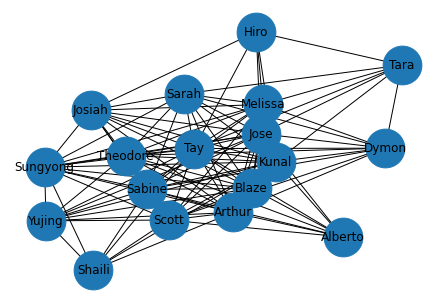

In [197]:
nx.draw(uG, with_labels=True, node_size=1500)

In [198]:
wG = nx.read_adjlist("adj_list.txt")

In [199]:
node_attributes = make_node_attribute_dict("responses.csv")

In [200]:
nx.set_node_attributes(uG, node_attributes)
nx.set_node_attributes(wG, node_attributes)

In [201]:
u_edge_attributes = make_edge_attribute_dict(uG, "responses.csv", False)
w_edge_attributes = make_edge_attribute_dict(wG, "responses.csv", True)

In [202]:
nx.set_edge_attributes(uG, u_edge_attributes)
nx.set_edge_attributes(wG, w_edge_attributes)

Graph Analysis

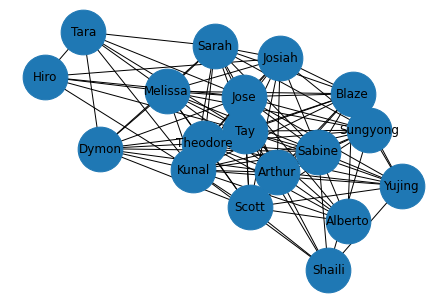

In [203]:
nx.draw(uG, node_size=2000, with_labels=True)

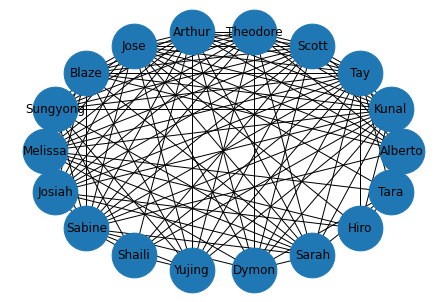

In [204]:
nx.draw_kamada_kawai(wG, node_size=2000, with_labels=True)

In [205]:
team_color_map = []
team = nx.get_node_attributes(wG, "Team")
for node in wG:
    if node not in team.keys():
        team_color_map.append("red")
    elif team[node] == "Tech":
        team_color_map.append("green")
    else:
        team_color_map.append("blue")

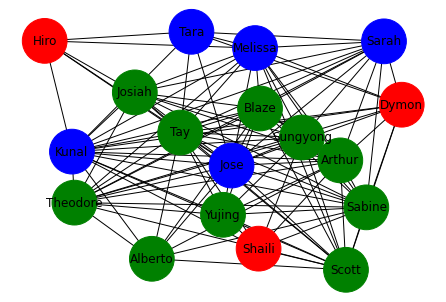

In [206]:
nx.draw(wG, node_size=2000, with_labels=True, node_color=team_color_map)

In [207]:
membership_color_map = []
membership = nx.get_node_attributes(wG, "Membership")
for node in wG:
    if node not in membership.keys():
        membership_color_map.append("red")
    elif membership[node] == "Member":
        membership_color_map.append("green")
    elif membership[node] == "Buddy":
        membership_color_map.append("yellow")
    else:
        membership_color_map.append("blue")

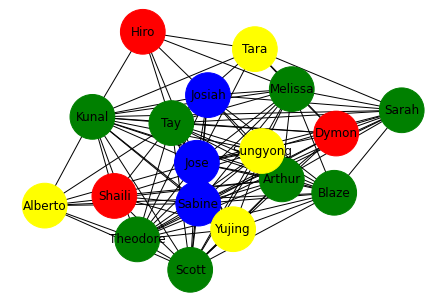

In [208]:
nx.draw(wG, node_size=2000, with_labels=True, node_color=membership_color_map)

In [209]:
military_color_map = []
military = nx.get_node_attributes(wG, "Mil")
for node in wG:
    if node not in membership.keys():
        military_color_map.append("brown")
    elif military[node] == True:
        military_color_map.append("green")
    else:
        military_color_map.append("coral")

In [210]:
def sort_centrality(cent_dict):
    sorted_list = sorted(cent_dict.items(), key=lambda x: x[1], reverse=True)
    return sorted_list

In [211]:
deg_cent = nx.degree_centrality(wG)
nx.set_node_attributes(wG, deg_cent, "Degree Centrality")
print(sort_centrality(deg_cent))

[('Kunal', 1.0), ('Tay', 1.0), ('Jose', 0.9411764705882353), ('Arthur', 0.8823529411764706), ('Sabine', 0.8823529411764706), ('Scott', 0.8235294117647058), ('Theodore', 0.8235294117647058), ('Melissa', 0.8235294117647058), ('Blaze', 0.7647058823529411), ('Sungyong', 0.7647058823529411), ('Josiah', 0.7058823529411764), ('Sarah', 0.7058823529411764), ('Yujing', 0.5882352941176471), ('Dymon', 0.5882352941176471), ('Alberto', 0.47058823529411764), ('Shaili', 0.4117647058823529), ('Tara', 0.4117647058823529), ('Hiro', 0.3529411764705882)]


In [212]:
closeness_cent = nx.closeness_centrality(wG, distance="weight") # Change FREQUENCY to DISTANCE in make_edge_attribute_dict() 
# for weight
nx.set_node_attributes(wG, closeness_cent, "Closeness Centrality")
print(sort_centrality(closeness_cent))

[('Alberto', 1.8888888888888888), ('Kunal', 1.8888888888888888), ('Tay', 1.8888888888888888), ('Scott', 1.8888888888888888), ('Theodore', 1.8888888888888888), ('Arthur', 1.8888888888888888), ('Jose', 1.8888888888888888), ('Blaze', 1.8888888888888888), ('Melissa', 1.8888888888888888), ('Josiah', 1.8888888888888888), ('Sabine', 1.8888888888888888), ('Dymon', 1.8888888888888888), ('Sarah', 1.8888888888888888), ('Sungyong', 0.7083333333333334), ('Hiro', 0.68), ('Yujing', 0.4358974358974359), ('Tara', 0.4146341463414634), ('Shaili', 0.3148148148148148)]


In [213]:
btnness_cent = nx.betweenness_centrality(wG, weight="weight") # Change FREQUENCY to DISTANCE in make_edge_attribute_dict() 
# for weight
nx.set_node_attributes(wG, btnness_cent, "Betweenness Centrality")
print(sort_centrality(btnness_cent))

[('Kunal', 8.837063444345427), ('Sarah', 2.2455881832569533), ('Scott', 1.8797506273148188), ('Sabine', 1.4333673167192218), ('Theodore', 1.1408534144444145), ('Tay', 0.5650107433679903), ('Blaze', 0.4185932176650574), ('Melissa', 0.35305212927173796), ('Alberto', 0.13420598512766205), ('Arthur', 0.08530640777808772), ('Jose', 0.07817083610299244), ('Josiah', 0.05459026225903176), ('Sungyong', 0.0), ('Shaili', 0.0), ('Yujing', 0.0), ('Dymon', 0.0), ('Hiro', 0.0), ('Tara', 0.0)]


In [214]:
eigen_cent = nx.eigenvector_centrality(wG, weight="weight") # Change DISTANCE to FREQUENCY in make_edge_attribute_dict() 
# for weight
nx.set_node_attributes(wG, eigen_cent, "Eigenvector Centrality")
print(sort_centrality(eigen_cent))

[('Jose', 0.32686121331973406), ('Yujing', 0.31650577170842104), ('Arthur', 0.2904518860153744), ('Sungyong', 0.29041107000916905), ('Tay', 0.2579382106489374), ('Shaili', 0.24686914745814906), ('Sabine', 0.24045136350828905), ('Blaze', 0.2320710055078595), ('Dymon', 0.22824920391151268), ('Melissa', 0.21129782468169322), ('Scott', 0.20797471876742343), ('Tara', 0.20435060722300968), ('Josiah', 0.20248397874384316), ('Sarah', 0.19546161097392104), ('Alberto', 0.19079898384308402), ('Kunal', 0.18657496584647038), ('Theodore', 0.16388454120080653), ('Hiro', 0.1615546645728893)]


In [215]:
#katz_cent = nx.katz_centrality(wG)
#nx.set_node_attributes(wG, katz_cent, "Katz Centrality")
#print(sort_centrality(katz_cent))

In [216]:
wG.nodes["Kunal"]["Degree Centrality"]

1.0

In [217]:
deg_cent_size_map = []
dc = nx.get_node_attributes(wG, "Degree Centrality")
for node in wG:
    deg_cent_size_map.append(1500 * dc[node])

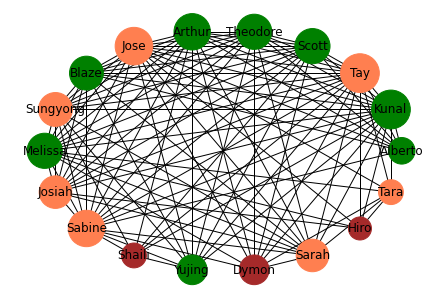

In [218]:
nx.draw_kamada_kawai(wG, node_size=deg_cent_size_map, with_labels=True, node_color=military_color_map)

In [219]:
closeness_cent_size_map = []
c = nx.get_node_attributes(wG, "Closeness Centrality")
for node in wG:
    closeness_cent_size_map.append(1000 * c[node])

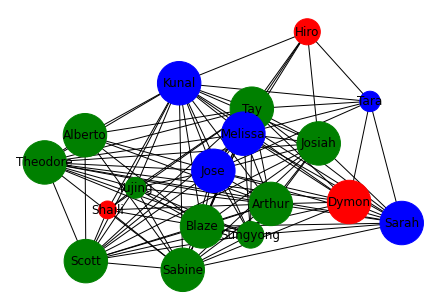

In [220]:
nx.draw(wG, node_size=closeness_cent_size_map, with_labels=True, node_color=team_color_map)

In [221]:
btnness_cent_size_map = []
bc = nx.get_node_attributes(wG, "Betweenness Centrality")
for node in wG:
    btnness_cent_size_map.append(1000 * bc[node])

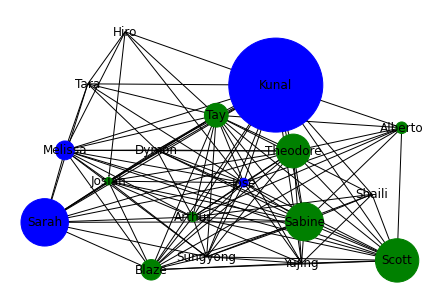

In [222]:
nx.draw(wG, node_size=btnness_cent_size_map, with_labels=True, node_color=team_color_map)

In [223]:
eigen_cent_size_map = []
ec = nx.get_node_attributes(wG, "Eigenvector Centrality")
for node in wG:
    eigen_cent_size_map.append(5000 * ec[node])

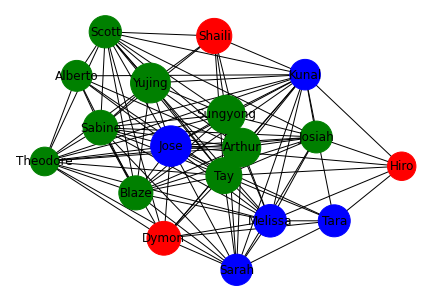

In [224]:
nx.draw(wG, node_size=eigen_cent_size_map, with_labels=True, node_color=team_color_map)

In [225]:
colors = ["red", "orange", "yellow", "green", "blue", "turquoise", "indigo", "violet", "brown", "pink", "purple"]

In [226]:
girv_new = cty.girvan_newman(wG)

In [227]:
gn_cty1 = next(girv_new)
tuple(sorted (p) for p in gn_cty1)

(['Alberto',
  'Arthur',
  'Blaze',
  'Dymon',
  'Jose',
  'Josiah',
  'Kunal',
  'Melissa',
  'Sabine',
  'Sarah',
  'Scott',
  'Shaili',
  'Sungyong',
  'Tara',
  'Tay',
  'Theodore',
  'Yujing'],
 ['Hiro'])

In [228]:
girv_new_color_map = []
for node in wG:
    color_index = 0
    for cty in range(len(gn_cty1)):
        if node in gn_cty1[cty]:
            girv_new_color_map.append(colors[color_index])
        elif color_index + 1 != len(colors):
            color_index += 1

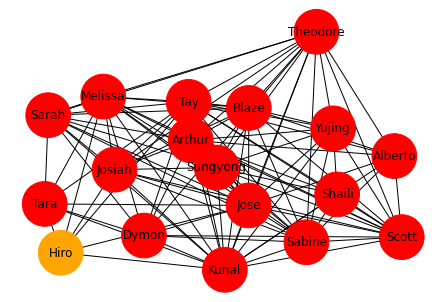

In [229]:
nx.draw(wG, with_labels=True, node_color=girv_new_color_map, node_size=2000)

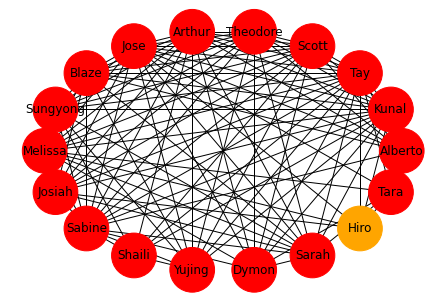

In [230]:
nx.draw_kamada_kawai(wG, with_labels=True, node_color=girv_new_color_map, node_size=2000)

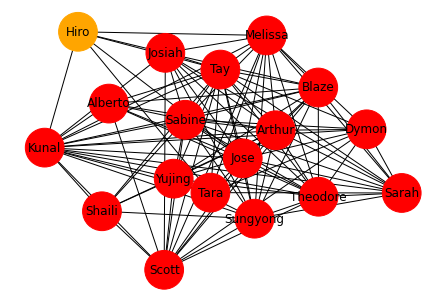

In [231]:
nx.draw_spring(wG, with_labels=True, node_color=girv_new_color_map, node_size=1500)

In [238]:
k_cliques = list(k_clique_communities(wG, 2))
print(k_cliques)

[frozenset({'Sarah', 'Tara', 'Jose', 'Dymon', 'Kunal', 'Alberto', 'Shaili', 'Hiro', 'Arthur', 'Josiah', 'Sabine', 'Theodore', 'Sungyong', 'Melissa', 'Yujing', 'Blaze', 'Scott', 'Tay'})]


In [233]:
k_clique_color_map = []
for node in wG:
    if node in k_cliques[0]:
        k_clique_color_map.append("green")
    else:
        k_clique_color_map.append("red")

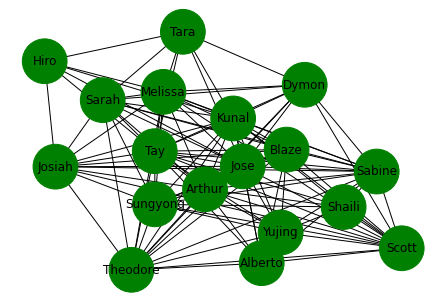

In [234]:
nx.draw(wG, node_size=2000, with_labels=True, node_color=k_clique_color_map)